## Integral LS equation

In [1]:
# for binder
ENV["PYTHON"] = ""
using Pkg;

using IMinuit, QuadGK, NLsolve, NIntegration;
using CSV, DataFrames, LaTeXStrings; ENV["COLUMNS"]=160;
import PyPlot;
using Plots; default(frame=:box, minorticks=5, size=(500,350));
using BenchmarkTools;


using LinearAlgebra, StaticArrays
using Roots
using DifferentialEquations
using Interpolations
using FastGaussQuadrature

PyPlot.matplotlib[:rc]("mathtext",fontset="cm");    
PyPlot.matplotlib[:rc]("font", family="serif", size=11);

In [2]:
#Pkg.add("PyCall")
#Pkg.build("PyCall")

In [3]:
#import Pkg; 
#Pkg.precompile()

In [4]:
include("quadgauss.jl");
include("hadronmasses.jl");

In [5]:
λ(a,b,c) = a^2+b^2+c^2-2a*b-2b*c-2a*c
qsq(E,m1,m2) = λ(E^2,m1^2,m2^2)/(4E^2)
# 2-body phase space factor
phsp(E,m1,m2) = sqrt(qsq(E,m1,m2))/(8*pi*E);



In [6]:
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end

ρ(w,m1,m2) = xsqrt(qsq(w,m1,m2)+0im)/(8π*w);

## LHCb data

In [7]:
# read the data from file and wrap that into Data defined in IMinuit
data_full_df=DataFrame(CSV.File("data10GeV_corrected.csv", header=["w", "y", "err"]))
const data_full=Data(data_full_df);

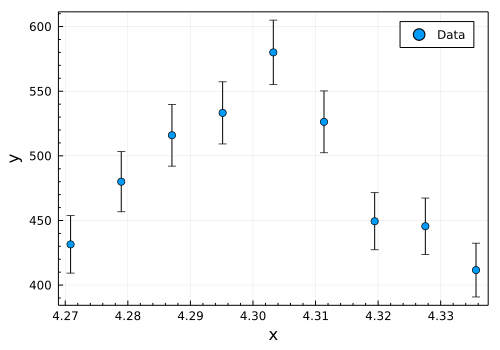

In [8]:
@plt_data data_full

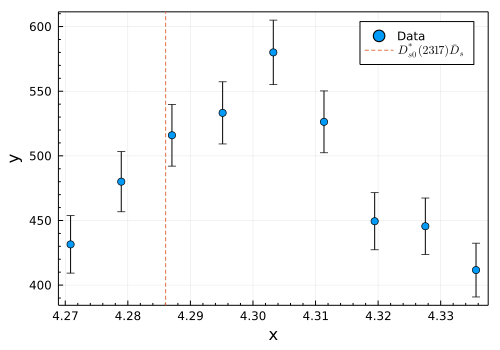

In [9]:
@plt_data data_full
#@plt_data! dps_data label="DPS" legend=:outerright size=(700,400)
#vline!([mLamc+mkc], line=:dash, label=L"J/\psi\psi'")
vline!([mds02317+mds], line=:dash, label=L"D_{s0}^{\ast}(2317)\bar{D}_s")

## Gauss-Legendre quadrature

In [10]:
function RectRootsWeight(a,b,NI)
    step = (b-a)/NI
    XI = collect(a+step/2:step:b)
    WI = ones(NI)*step
    return XI,WI
end


RectRootsWeight (generic function with 1 method)

In [11]:
function GaussRootsWeight(a,b,NI)#::Tuple(Float64,Float64)
    TI,WTI=gausslegendre(NI) ; # (-1,1)
    XI = (b-a)/2.0e0*TI .+ (b+a)/2.0e0
    WI = (b-a)/2.0e0*WTI
    return XI,WI
end

GaussRootsWeight (generic function with 1 method)

In [12]:
const ϵ=1e-8;

const NZ = 5;
const xx1, ww1 = GaussRootsWeight(0,20.,NZ);

In [13]:
const m1=mds;
const m2=mds02317;
const geff=9.3*0.77; # in unit of GeV
const metaeff=0.421;# \sqrt{-\delta E^2+ meta^2} in unit of GeV

#const Λ=1.0;

In [14]:
function vGau(m1,m2,mex,geff0,p1,p2, Λ)
    
  @fastmath Vopess=geff0*1/(4p1*p2)*log(((p1+p2)^2 +mex^2)/((p1-p2)^2 +mex^2) )#*exp(-(p1^2+p2^2)/(Λ^2))
        
    return -1/(4m1*m2)*Vopess*(1/2)
end

#1/(4m1*m2) is replaced by 1/(m1*m2) in HQEFT?, 
#where 1/2 coresponds to Ds0 Dsbar->Ds0bar Ds with respect to eigenvalues of {{0,1/2},{1/2,0}}

vGau (generic function with 1 method)

##### Details in OPE
1/(4m1*m2) is replaced by 1/(m1*m2) in HQEFT? 
The factor 1/2 coresponds to Ds0 Dsbar->Ds0bar Ds with respect to eigenvalues of {{0,1/2},{1/2,0}}.

In [15]:
function Ginte(w,q,m1,m2)
    mu=m1*m2/(m1+m2);
    Gint=q^2/(2pi^2)*1/(w-m1-m2-q^2/(2mu))
end

Ginte (generic function with 1 method)

In [16]:
function Gintesep0(w,q,m1,m2,Λ)
    mu=m1*m2/(m1+m2);
    psq=abs(2mu*(m1+m2-w));
    
    Gint0=q^2/(2pi^2)*1/(w-m1-m2-q^2/(2mu)+1im*ϵ)*exp(-2q^2/(Λ^2))-(2mu*(w-m1-m2))/(2pi^2)*1/(w-m1-m2-q^2/(2mu)+1im*ϵ)*exp(-2psq/(Λ^2))
    if w<m1+m2
        Gint=Gint0+1/(2pi)*xsqrt(2mu*(m1+m2-w))*exp(-2psq/(Λ^2))
        else Gint=Gint0+1im/(2pi)*xsqrt(2mu*(w-m1-m2))*exp(-2psq/(Λ^2))
    end
    return Gint
end

function Gintesep(w,q,m1,m2,Λ)
    mu=m1*m2/(m1+m2);
    psq=abs(2mu*(m1+m2-w));
    
    Gint=q^2/(2pi^2)*1/(w-m1-m2-q^2/(2mu)+1im*ϵ)*exp(-2q^2/(Λ^2))-(2mu*(w-m1-m2))/(2pi^2)*1/(w-m1-m2-q^2/(2mu)+1im*ϵ)*exp(-2psq/(Λ^2))
   
    return Gint
end

Gintesep (generic function with 1 method)

In [17]:
const Nq =25;
const a0=0.;
const b0=2.0;
 xx2, ww2 = GaussRootsWeight(a0,b0,Nq);




function VGgaussRS(w,m1,m2,mex,geff0, Λ)
    mu=m1*m2/(m1+m2);
    psq=abs(2mu*(m1+m2-w));
    t=0im
    VG(q)=vGau(m1,m2,mex,geff0,q,q,Λ)*Gintesep(w,q,m1,m2,Λ)
  
       for i in 1:Nq
        t+=(VG(xx2[i])*ww2[i])
    end
     if w<m1+m2
        t+=1/(2pi)*xsqrt(2mu*(m1+m2-w))*exp(-2psq/(Λ^2))*vGau(m1,m2,mex,geff0,xsqrt(2mu*(m1+m2-w)),xsqrt(2mu*(m1+m2-w)),Λ)
        else t+=1im/(2pi)*xsqrt(2mu*(w-m1-m2))*exp(-2psq/(Λ^2))*vGau(m1,m2,mex,geff0,xsqrt(2mu*(w-m1-m2)),xsqrt(2mu*(w-m1-m2)),Λ)
    end
    
    return t
end

VGgaussRS (generic function with 1 method)

In [18]:
@time VGgaussRS(4.27,mds,mds02317,0.4,1, 1)

  0.058261 seconds (190.36 k allocations: 10.733 MiB, 44.02% gc time, 99.74% compilation time)


0.002659737094869577 + 1.8894603278265956e-9im

In [19]:
function VGgauss0(w)
   VGgaussRS(w,mds,mds02317,0.4,1.0, 1.0)
end

VGgauss0 (generic function with 1 method)

In [20]:
VGgauss0(4.282)

0.0038207821768766513 + 4.8834685590198994e-9im

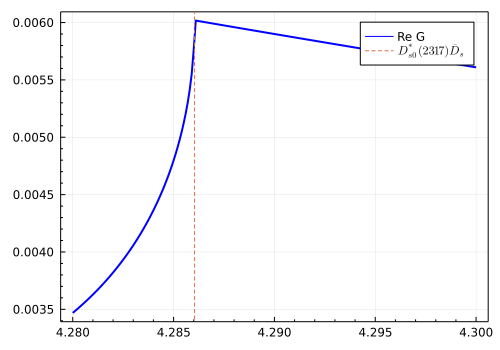

In [21]:

x =4.28:0.0001: 4.30
y1 = [real(VGgauss0.(x))]

Plots.plot(x, y1, color=:blue, linewidth=2, label="Re G")
vline!([mds02317+mds], line=:dash, label=L"D_{s0}^{\ast}(2317)\bar{D}_s")

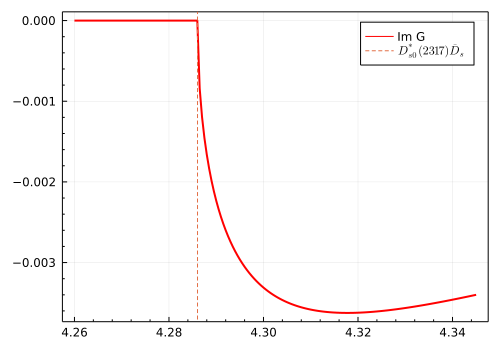

In [22]:
x = 4.260: 0.0005: 4.345
y2 = [imag(VGgauss0.(x))]

Plots.plot(x, y2, color=:red, linewidth=2, label="Im G")
vline!([mds02317+mds], line=:dash, label=L"D_{s0}^{\ast}(2317)\bar{D}_s")

In [23]:
mds+mds02317

4.28604

In [24]:
function dist0(w,par)
   a1,a2,vp,geff=par
      @fastmath amp=vp/(1-VGgaussRS(w,m1,m2,metaeff,geff^2, 1.0) +a1*qsq(w,mjψ,mphi)+1im*a2)
    return (abs2(amp)* phsp(w,mjψ,mphi)*qsq(w,mjψ,mphi))
end

function dist01(w,par)
   a1,a2,vp,geff=par
      @fastmath amp=vp/(1-VGgaussRS(w,m1,m2,metaeff,geff^2, 1.5) +a1*qsq(w,mjψ,mphi)+1im*a2)
    return (abs2(amp)* phsp(w,mjψ,mphi)*qsq(w,mjψ,mphi))
end

dist01 (generic function with 1 method)

In [25]:
function dist1(w,par)
   a1,a2,vp,geff=par
      @fastmath amp=vp/(1-VGgaussRS(w,m1,m2,metaeff,geff^2, 1.0) +a1*qsq(w,mjψ,mphi)+1im*a2)
    return (abs2(amp)* phsp(w,mjψ,mphi))
end

function dist10(w,par)
   a1,a2,vp,geff=par
      @fastmath amp=vp/(1-VGgaussRS(w,m1,m2,metaeff,geff^2, 1.5) +a1*qsq(w,mjψ,mphi)+1im*a2)
    return (abs2(amp)* phsp(w,mjψ,mphi))
end


function dist11(w,par)
   a1,a2,vp,geff=par
      @fastmath amp=vp/(1-VGgaussRS(w,m1,m2,metaeff,geff^2, 0.5) +a1*qsq(w,mjψ,mphi)+1im*a2)
    return (abs2(amp)* phsp(w,mjψ,mphi))
end


dist11 (generic function with 1 method)

In [26]:
@time dist0(4.2,ones(5))

  0.010918 seconds (29.18 k allocations: 1.601 MiB, 99.39% compilation time)


0.00019818135453402892

In [27]:
const ndata=9;
const nvar=4;
const parname = [:a1,:a2,:vp,:geff];

## Fitting

In [28]:
function makefit(fit::AbstractFit; dof=ndata-nvar, printout=true)
    migrad(fit); migrad(fit); hesse(fit)
    printout && println("χ²/dof = ", fit.fva/ldof)
    migrad(fit)
end

function do_minos(fit)
    migrad(fit); minos(fit); migrad(fit)
end

do_minos (generic function with 1 method)

In [29]:
"""
search_init_rand(fun, data; nrand=100, dof=4, onlynan=false, nchannels=2, par...)

search for proper initial values for the LECs with Monte Carlo in the range [-50, 50] for 2-channel fit.
* keep only the initial values leading to a fit with χ²/dof < 1.25 and that the corresponding 
1st sheet pole is not found if `onlynan=true` or the im part is larger than 0.3 GeV if `onlynan=false`; 
real pole on 1st sheet is kept.
* `nchannels=2` for two channels and `nchannels=3` for three channels 
"""
function search_init_rand(fun, data; nrand=100, dof=ndata-nvar, onlynan=false,par...)
    df = DataFrame(chisq = Real[], lecs_init = Tuple[], lecs_final = Tuple[])   
    #nlecs = nchannels ==2 ? 2 : 2
    ar = zeros(nvar)
    
    for i = 1:nrand
        ar .= rand(-50:0.001:50, nvar)
      
            _initval = (ar...,)  
            _fit = model_fit(fun, data, _initval; name=parname,  par...)
        _fit.strategy = 2
        migrad(_fit); migrad(_fit)
        _chsq = _fit.fval/dof
        (_chsq <1.25)  && push!(df, (round(_chsq, digits=4), _initval, Tuple(args(_fit))) )
    end
    sort!(df)
    return unique!(df, :chisq)
    
end

search_init_rand

In [30]:
@time search_init_rand(dist0, data_full[1:ndata], nrand=2000, onlynan=true)

139.666964 seconds (4.62 G allocations: 133.962 GiB, 15.36% gc time, 0.91% compilation time)


,chisq,lecs_init,lecs_final
,Real,Tuple,Tuple
1,1.0076,"(-48.993, 15.304, 30.768, 4.947)","(-3.75507, -0.376845, 233.603, 3.02067)"
2,1.1287,"(-49.764, 32.991, -32.309, -0.18)","(-3.69653, 0.333014, -209.389, 0.000172816)"
3,1.1288,"(4.575, 1.303, 5.361, 29.881)","(-3.69631, 0.332817, -209.264, 0.0119976)"


In [123]:
@time search_init_rand(dist01, data_full[1:ndata], nrand=2000, onlynan=true)

,chisq,lecs_init,lecs_final
,Real,Tuple,Tuple
1,1.0052,"(-49.644, -28.617, -33.16, 37.481)","(-3.7254, -0.376535, -233.438, -2.99556)"
2,1.1287,"(-49.654, -10.603, 10.218, -34.072)","(-3.69654, 0.333015, 209.39, 0.000108537)"
3,1.1288,"(-0.696, 40.391, 21.391, -48.678)","(-3.69699, 0.333179, 209.493, -0.0146747)"


144.766533 seconds (4.68 G allocations: 135.523 GiB, 17.71% gc time, 0.02% compilation time)


In [124]:
@time search_init_rand(dist1, data_full[1:ndata], nrand=2000, onlynan=true)

124.677984 seconds (4.00 G allocations: 116.471 GiB, 17.25% gc time, 0.03% compilation time)


,chisq,lecs_init,lecs_final
,Real,Tuple,Tuple
1,1.0992,"(-49.96, 45.164, 4.887, -5.204)","(-3.51578, -0.398895, -127.291, -2.69414)"
2,1.1889,"(-49.349, -7.608, 47.862, -6.122)","(-3.47724, 0.338789, 111.879, 0.000296836)"


In [125]:
@time search_init_rand(dist11, data_full[1:ndata], nrand=2000, onlynan=true)

,chisq,lecs_init,lecs_final
,Real,Tuple,Tuple
1,1.0998,"(-49.678, -11.556, 17.689, 40.642)","(-3.5399, -0.399654, 127.64, -2.79664)"
2,1.0999,"(-47.679, 10.806, 14.256, -47.479)","(-3.54114, -0.400778, 127.946, 2.82269)"
3,1.1889,"(-49.345, -32.835, 35.791, 2.016)","(-3.47724, 0.338788, 111.878, 4.10815e-5)"


 87.899052 seconds (2.78 G allocations: 80.911 GiB, 17.74% gc time, 0.04% compilation time)


In [126]:
const mu0=m1*m2/(m1+m2);
xsqrt(-2mu0*(m1+m2-4.26))

0.0 + 0.23544314336571903im

In [127]:
xsqrt(qsq(4.26,m1,m2))

0.0 + 0.235075619456549im

## Fiting scheme-II

In [128]:
function dist2(w,par)
  a1, a2,vp=par
    
      @fastmath amp=vp/(1-VGgaussRS(w,m1,m2,metaeff,1/4*geff^2, 1.0) +a1*qsq(w,mjψ,mphi)+1im*a2)
    return (abs2(amp)* phsp(w,mjψ,mphi))
end

dist2 (generic function with 1 method)

In [129]:
function dist3(w,par)
  a1, a2,vp=par
    
      @fastmath amp=vp/(1-VGgaussRS(w,m1,m2,metaeff,1/4*geff^2, 1.0) +a1*qsq(w,mjψ,mphi)+1im*a2*qsq(w,mjψ,mphi))
    return (abs2(amp)* phsp(w,mjψ,mphi))
end

dist3 (generic function with 1 method)

In [130]:
const ndata=9;
const nvar=3;
const parname = [:a1,:a2,:vp];

In [131]:
function search_init_rand(fun, data; nrand=100, dof=ndata-nvar, onlynan=false,par...)
    df = DataFrame(chisq = Real[], lecs_init = Tuple[], lecs_final = Tuple[])   
    #nlecs = nchannels ==2 ? 2 : 2
    ar = zeros(nvar)
    
    for i = 1:nrand
        ar .= rand(-50:0.001:50, nvar)
      
            _initval = (ar...,)  
            _fit = model_fit(fun, data, _initval; name=parname,  par...)
        _fit.strategy = 2
        migrad(_fit); migrad(_fit)
        _chsq = _fit.fval/dof
        (_chsq <1.25)  && push!(df, (round(_chsq, digits=4), _initval, Tuple(args(_fit))) )
    end
    sort!(df)
    return unique!(df, :chisq)
    
end

search_init_rand (generic function with 1 method)

In [132]:
@time search_init_rand(dist2, data_full[1:ndata], nrand=20000, onlynan=true)

337.433793 seconds (11.32 G allocations: 329.580 GiB, 17.12% gc time, 0.02% compilation time)


,chisq,lecs_init,lecs_final
,Real,Tuple,Tuple
1,0.9459,"(-49.956, 12.878, 48.471)","(-3.55084, -0.437467, 137.837)"


In [133]:

@time search_init_rand(dist3, data_full[1:ndata], nrand=2000, onlynan=true)

 33.739938 seconds (1.22 G allocations: 35.537 GiB, 17.06% gc time, 0.20% compilation time)


,chisq,lecs_init,lecs_final
,Real,Tuple,Tuple
1,0.9991,"(-49.996, 25.736, -48.365)","(-2.91569, -1.54035, -140.012)"


In [134]:
function dist4(w,par)
  a1, a2,vp=par
    
      @fastmath amp=vp/(1-VGgaussRS(w,m1,m2,metaeff,1/4*geff^2, 1.0) +a1+1im*a2)
    return (abs2(amp)* phsp(w,mjψ,mphi))
end

dist4 (generic function with 1 method)

In [135]:
@time search_init_rand(dist4, data_full[1:ndata], nrand=5000, onlynan=true)

119.824510 seconds (4.32 G allocations: 125.821 GiB, 17.06% gc time, 0.02% compilation time)


,chisq,lecs_init,lecs_final
,Real,Tuple,Tuple


In [48]:
const ndata=9;
const nvar=3;
const parname = [:a2,:vp,:geff];

In [49]:
function dist5(w,par)
   a2,vp,geff=par
    
      @fastmath amp=vp/(1-VGgaussRS(w,m1,m2,metaeff,geff^2, 1.0) +1im*a2)
    return (abs2(amp)* phsp(w,mjψ,mphi))
end

dist5 (generic function with 1 method)

In [52]:
function search_init_rand(fun, data; nrand=100, dof=ndata-nvar, onlynan=false,par...)
    df = DataFrame(chisq = Real[], lecs_init = Tuple[], lecs_final = Tuple[])   
    #nlecs = nchannels ==2 ? 2 : 2
    ar = zeros(nvar)
    
    for i = 1:nrand
        ar .= rand(-50:0.001:50, nvar)
      
            _initval = (ar...,)  
            _fit = model_fit(fun, data, _initval; name=parname,  par...)
        _fit.strategy = 2
        migrad(_fit); migrad(_fit)
        _chsq = _fit.fval/dof
        (_chsq <10)  && push!(df, (round(_chsq, digits=4), _initval, Tuple(args(_fit))) )
    end
    sort!(df)
    return unique!(df, :chisq)
end

search_init_rand (generic function with 1 method)

In [53]:
@time search_init_rand(dist5, data_full[1:ndata], nrand=5000, onlynan=true)

237.546778 seconds (7.96 G allocations: 232.431 GiB, 16.26% gc time, 0.03% compilation time)


,chisq,lecs_init,lecs_final
,Real,Tuple,Tuple
1,6.9705,"(-49.991, -44.084, -38.261)","(0.457966, -294.926, -7.35989)"


## Fitting result

In [136]:
const a1Fit=-3.55084;#chisq=0.9459,Lambda=1.0 GeV;
const a2Fit=-0.437467;
const vpFit=-137.837;


In [137]:
function dist2Fit(w)
   a1=a1Fit;
    a2=a2Fit;
    vp=vpFit;
    
     @fastmath amp=vp/(1-VGgaussRS(w,m1,m2,metaeff,1/4*geff^2, 1.0) +a1*qsq(w,mjψ,mphi)+1im*a2)
    return (abs2(amp)* phsp(w,mjψ,mphi))
end

dist2Fit (generic function with 1 method)

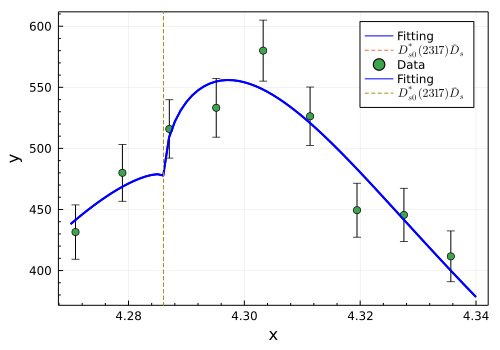

In [140]:
x = 4.270: 0.001: 4.34
y = [dist2Fit.(x)]
@plt_data! data_full
Plots.plot!(x, y, color=:blue, linewidth=2, label="Fitting")
vline!([mds02317+mds], line=:dash, label=L"D_{s0}^{\ast}(2317)\bar{D}_s")